/home/bongiwe/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Processing: data_C
	 Total number of collisions (events) in data_C: 2237187
	 Reading 2237187 events (100% of the total)
	 nIn: 151639,	 nOut: 4670	 in 1.8s
	 nIn: 151639,	 nOut: 4752	 in 3.7s
	 nIn: 151639,	 nOut: 4739	 in 5.6s
	 nIn: 151639,	 nOut: 4806	 in 7.5s
	 nIn: 151639,	 nOut: 4747	 in 9.3s
	 nIn: 151639,	 nOut: 4659	 in 11.2s
	 nIn: 151639,	 nOut: 4556	 in 13.0s
	 nIn: 151639,	 nOut: 4713	 in 15.0s
	 nIn: 151639,	 nOut: 4847	 in 17.0s
	 nIn: 151639,	 nOut: 4803	 in 19.1s
	 nIn: 151639,	 nOut: 4789	 in 21.3s
	 nIn: 151639,	 nOut: 4545	 in 23.5s
	 nIn: 151639,	 nOut: 4717	 in 25.5s
	 nIn: 151639,	 nOut: 4819	 in 27.6s
	 nIn: 114241,	 nOut: 3729	 in 29.3s

Time taken: 29.5s
Number of events after all selection cuts: 69891


Total Higgs signal events (Gaussian area): 609.7
Total background events (under fit): 33169.2
Mean invariant mass of Higgs signal region (~125 GeV): 128.29 GeV
Standard deviation of Higgs signal region: 1.51 GeV
Mean invariant mass of background region: 136.0

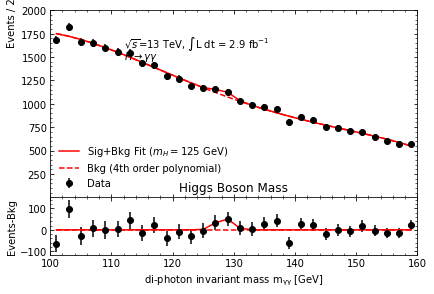

In [1]:
import sys
import uproot3
import pandas as pd
import time
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, AutoMinorLocator
from lmfit.models import PolynomialModel, GaussianModel
from sklearn.metrics import roc_curve, auc

# Luminosity settings
#lumi = 0.5 # fb-1 # data_A only
#lumi = 1.9 # fb-1 # data_B only
#lumi = 2.9 # fb-1 # data_C only
#lumi = 4.7 # fb-1 # data_D only


# Luminosity settings
lumi =  2.9
fraction = 1
tuple_path = "/home/bongiwe/Documents/GamGam/Data/"
samples_list = ['data_C']

def calc_myy(photon_pt, photon_eta, photon_phi, photon_E):
    px_0 = photon_pt[0] * math.cos(photon_phi[0])
    py_0 = photon_pt[0] * math.sin(photon_phi[0])
    pz_0 = photon_pt[0] * math.sinh(photon_eta[0])
    px_1 = photon_pt[1] * math.cos(photon_phi[1])
    py_1 = photon_pt[1] * math.sin(photon_phi[1])
    pz_1 = photon_pt[1] * math.sinh(photon_eta[1])
    sumpx = px_0 + px_1
    sumpy = py_0 + py_1
    sumpz = pz_0 + pz_1
    sump = math.sqrt(sumpx ** 2 + sumpy ** 2 + sumpz ** 2)
    sumE = photon_E[0] + photon_E[1]
    return math.sqrt(sumE ** 2 - sump ** 2) / 1000  # MeV to GeV

def cut_photon_reconstruction(photon_isTightID):
    return photon_isTightID[0] and photon_isTightID[1]

def cut_photon_pt(photon_pt):
    return photon_pt[0] > 48000 and photon_pt[1] > 32000

def cut_isolation_et(photon_etcone20):
    return photon_etcone20[0] < 3600 and photon_etcone20[1] < 3600

def cut_photon_eta_transition(photon_eta):
    return not (1.37 < abs(photon_eta[0]) < 1.52 or 1.37 < abs(photon_eta[1]) < 1.52)



#def cut_photon_eta_transition(photon_eta):
#    return (abs(photon_eta[0]) > 1.60 or abs(photon_eta[0]) < 1.45) and (abs(photon_eta[1]) > 1.60 or abs(photon_eta[1]) < 1.45)

def read_file(path, sample):
    start = time.time()
    print(f"Processing: {sample}")
    data_all = pd.DataFrame()
    try:
        tree = uproot3.open(path)["mini"]
        numevents = uproot3.numentries(path, "mini")
        print(f"\t Total number of collisions (events) in {sample}: {numevents}")
        print(f"\t Reading {int(numevents * fraction)} events ({fraction * 100:.0f}% of the total)")
    except FileNotFoundError:
        print(f"Error: File {path} not found.")
        return data_all

    for data in tree.iterate(["photon_pt", "photon_eta", "photon_phi", "photon_E",
                              "photon_isTightID", "photon_etcone20"],
                             outputtype=pd.DataFrame,
                             entrystop=int(numevents * fraction)):

        nIn = len(data.index)
        data = data[np.vectorize(cut_photon_reconstruction)(data.photon_isTightID)]
        data = data[np.vectorize(cut_photon_pt)(data.photon_pt)]
        data = data[np.vectorize(cut_isolation_et)(data.photon_etcone20)]
        data = data[np.vectorize(cut_photon_eta_transition)(data.photon_eta)]
        data['myy'] = np.vectorize(calc_myy)(data.photon_pt, data.photon_eta, data.photon_phi, data.photon_E)

        nOut = len(data.index)
        data_all = data_all._append(data)
        elapsed = time.time() - start
        print(f"\t nIn: {nIn},\t nOut: {nOut}\t in {round(elapsed, 1)}s")

    return data_all

def get_data_from_files():
    frames = []
    for val in samples_list:
        fileString = tuple_path + val + ".GamGam.root"
        temp = read_file(fileString, val)
        frames.append(temp)
    return pd.concat(frames)

def plot_data(data):
    if data.empty:
        print("Error: No data available to plot.")
        return

    xmin, xmax, step_size = 100, 160, 2
    bin_edges = np.arange(xmin, xmax + step_size, step_size)
    bin_centres = bin_edges[:-1] + step_size / 2

    data_x, _ = np.histogram(data['myy'], bins=bin_edges)
    data_x_errors = np.sqrt(data_x)

    polynomial_mod = PolynomialModel(4)
    gaussian_mod = GaussianModel()

    pars = polynomial_mod.guess(data_x, x=bin_centres)
    pars += gaussian_mod.guess(data_x, x=bin_centres, amplitude=100, center=125, sigma=2)
    model = polynomial_mod + gaussian_mod
    out = model.fit(data_x, pars, x=bin_centres, weights=1/data_x_errors)

    p = out.params.valuesdict()
    background = p['c0'] + p['c1'] * bin_centres + p['c2'] * bin_centres**2 + \
                 p['c3'] * bin_centres**3 + p['c4'] * bin_centres**4
    signal_x = data_x - background

    # --- Calculate signal and background events ---
    amplitude = out.params['amplitude'].value
    sigma = out.params['sigma'].value
    signal_yield = amplitude * sigma * np.sqrt(2 * np.pi)
    background_yield = np.sum(background)

    print(f"\nTotal Higgs signal events (Gaussian area): {signal_yield:.1f}")
    print(f"Total background events (under fit): {background_yield:.1f}")

    # --- Calculate mean and standard deviation of Higgs signal and background values ---
    center = out.params['center'].value
    lower = center - 2 * sigma
    upper = center + 2 * sigma

    higgs_region = data[(data['myy'] >= lower) & (data['myy'] <= upper)]
    background_region = data[(data['myy'] < lower) | (data['myy'] > upper)]

    higgs_mean = higgs_region['myy'].mean()
    background_mean = background_region['myy'].mean()

    higgs_std = higgs_region['myy'].std()  # Standard deviation for Higgs signal region
    background_std = background_region['myy'].std()  # Standard deviation for background region

    print(f"Mean invariant mass of Higgs signal region (~125 GeV): {higgs_mean:.2f} GeV")
    print(f"Standard deviation of Higgs signal region: {higgs_std:.2f} GeV")
    print(f"Mean invariant mass of background region: {background_mean:.2f} GeV")
    print(f"Standard deviation of background region: {background_std:.2f} GeV\n")

    # Save the results to the respective files
    with open('signal.dat', 'w') as signal_file:
        signal_file.write(f"{higgs_mean:.2f}\t{higgs_std:.2f}\t{signal_yield:.1f}\n")
    
    with open('background.dat', 'w') as background_file:
        background_file.write(f"{background_mean:.2f}\t{background_std:.2f}\t{background_yield:.1f}\n")

    # --- Plotting ---
    plt.figure(figsize=(6, 4))
    plt.axes([0.1, 0.3, 0.85, 0.65])
    main_axes = plt.gca()

    main_axes.errorbar(bin_centres, data_x, yerr=data_x_errors, fmt='ko', label='Data')
    main_axes.plot(bin_centres, out.best_fit, '-r', label='Sig+Bkg Fit ($m_H=125$ GeV)')
    main_axes.plot(bin_centres, background, '--r', label='Bkg (4th order polynomial)')
    main_axes.set_xlim(xmin, xmax)
    main_axes.set_ylim(0, np.amax(data_x) * 1.1)
    main_axes.set_ylabel(f'Events / {step_size} GeV')
    main_axes.legend(frameon=False, loc='lower left')
    main_axes.tick_params(which='both', direction='in', top=True, labelbottom=False, right=True)
    main_axes.xaxis.set_minor_locator(AutoMinorLocator())
    main_axes.yaxis.set_minor_locator(AutoMinorLocator())
    main_axes.yaxis.get_major_ticks()[0].set_visible(False)

    lumi_used = str(lumi * fraction)
    plt.text(0.2, 0.8, r'$\sqrt{s}$=13 TeV, $\int$L dt = ' + lumi_used + ' fb$^{-1}$', transform=main_axes.transAxes)
    plt.text(0.2, 0.74, r'$H \rightarrow \gamma\gamma$', transform=main_axes.transAxes)

    plt.axes([0.1, 0.1, 0.85, 0.2])
    sub_axes = plt.gca()
    sub_axes.errorbar(bin_centres, signal_x, yerr=data_x_errors, fmt='ko')
    sub_axes.plot(bin_centres, out.best_fit - background, '-r')
    sub_axes.plot(bin_centres, background - background, '--r')
    sub_axes.set_xlim(xmin, xmax)
    sub_axes.set_ylabel("Events-Bkg")
    sub_axes.set_xlabel(r'di-photon invariant mass $\mathrm{m_{\gamma\gamma}}$ [GeV]')
    sub_axes.xaxis.set_minor_locator(AutoMinorLocator())
    sub_axes.yaxis.set_minor_locator(AutoMinorLocator())
    sub_axes.tick_params(which='both', direction='in', top=True, right=True)

    main_axes.yaxis.set_label_coords(-0.09, 1)
    sub_axes.yaxis.set_label_coords(-0.09, 0.5)

    print(f"Fitted Higgs mass peak: {center:.8f} GeV")

    plt.title("Higgs Boson Mass")
    plt.savefig("figure.png")
    plt.show()

# Main processing
start = time.time()
data = get_data_from_files()
print(f"\nTime taken: {round(time.time() - start, 1)}s")
print(f"Number of events after all selection cuts: {len(data)}\n")
plot_data(data)
